In [91]:
from nltk.corpus import wordnet, words
import nltk
import re
import json
from nltk.sentiment import SentimentIntensityAnalyzer

import matplotlib.pyplot as plt
with open('./data/manywords_pos.txt') as f:
    manywords_pos = f.read()
    exec(f'manywords_pos = {manywords_pos}') #convert the string to original list

## Syn Net

- find networks for each part of speech, see if they are organized in clusters or what
- color nodes by sentiment (make it just binary good/bad for now), and observe any gradients
    - how easy is it (or "how short of a walk is it") to go from one polar sentiment to the next?
- degree distr

Synset methods: .name, .pos

Preprocessing:
- don't want VBD (past tense) or VBG (gerund or past particple) as this is redundant
- This is removing some wrong things e.g barefooted ("I barefooted" makes it VBD) when it's an adj

Quick guides:
    
    n NOUN

    v VERB

    a ADJECTIVE

    s ADJECTIVE SATELLITE

    r ADVERB

In [234]:
# Collecting all words
# some functions to search words for undesirable properties
def has_undesirable(inputStr):
    total_bool = bool(re.search(r'\d', inputStr)) or any(not c.isalnum() for c in inputStr) or any(c.isupper() for c in inputStr) or len(inputStr) ==1
    return total_bool

manywords = words.words() + list(wordnet.words())
manywords = list(dict.fromkeys(manywords)) #remove duplicates
#df = pd.read_csv('./data/all_words.txt', sep=' ', header=None) #just words
manywords = [i for i in manywords if has_undesirable(i) == False]

In [235]:
# assigning words their (potentially) multiple parts of speech
pos_map = {'NN':'n', 'VB':'v', 'JJ':'a'} #for mapping words w/o syns
manywords_pos = [] #[(word1, pos), ...]
for w in manywords:
    if nltk.pos_tag(['I',w])[1][1] == 'VBD' or nltk.pos_tag([w])[0][1] == 'VBG': # hack to tell if this is a redundant word. First case guarantees it is in fact a VBD, 
        continue                                                                 # second case uses only the word for cases like 'passing' (which can be NN)
        
    syns = wordnet.synsets(w)
    if len(syns) > 0:
        word_pos = [] # [(word,pos1),...,(word,posN)]
        psos = list(dict.fromkeys([s.pos() for s in syns])) # duplicates removed parts of speech
        for pos in psos:
            word_pos.append((w,pos))
        for wp in word_pos:
            manywords_pos.append(wp)
    else:
        pos = nltk.pos_tag([w])[0][1]
        try:
            pos = pos_map[pos]
            manywords_pos.append((w,pos))
        except:
            continue
            
with open('./data/manywords_pos.txt', 'w') as f:
    f.write(str(manywords_pos))

In [236]:
pos_subsets = dict.fromkeys(('n','v','a','s','r'))
for pos in pos_subsets.keys():
    pos_subset = [(w,p) for (w,p) in manywords_pos if p == pos]
    pos_subsets[pos] = pos_subset
    
polarity_done = False #if it was done previously
SIA = SentimentIntensityAnalyzer()
graphs = dict.fromkeys(pos_subsets.keys())
non_sentim = []
for g in graphs.keys():
    graphs[g] = {'nodes' : [],'edges' : []}

for pos in graphs.keys():
    edges_cache = []
    for (w,p) in pos_subsets[pos]:
        wp = f'{w}.{p}' 
        syns = [syn for syn in wordnet.synsets(w) 
                        if syn.pos() == p #right POS
                        and syn.name()[:syn.name().index('.')] != wp[:-2] #is not the same word
                        and '_' not in syn.name()] #no non-single words
        #nodes
        if not polarity_done:
            scores = SIA.polarity_scores(w); del scores['compound']
            try:
                sentm = [key for key in scores.keys() if scores[key] == 1.0][0]
                graphs[pos]['nodes'].append({**{"word":wp}, **{'sentm':sentm}})
                #edges
                for syn in syns:
                    syn = syn.name()[:-3] #removing number at end; maybe revise later to ensure no significant loss
                    if {wp,syn} not in edges_cache and tuple(syn.split('.')) in pos_subsets[pos]: # since underiected graph
                        edges_cache.append({wp,syn})
                        graphs[pos]['edges'].append({"source":wp,"target":syn})
            except:
                non_sentim.append(wp)
                continue
            
        else:
            pass #todo
    with open(f'./data/syn_graph/syn_graph_{pos}.json','w') as f:
        json.dump(graphs[pos],f,indent=4)

In [238]:
len(graphs['v']['nodes'])

10491

In [231]:
non_sentim

['a.n',
 'b.n',
 'c.n',
 'd.n',
 'e.n',
 'f.n',
 'g.n',
 'h.n',
 'i.n',
 'j.n',
 'k.n',
 'l.n',
 'm.n',
 'n.n',
 'o.n',
 'p.n',
 'q.n',
 'r.n',
 's.n',
 't.n',
 'u.n',
 'v.n',
 'w.n',
 'x.n',
 'y.n',
 'z.n',
 'c.s',
 'd.s',
 'i.s',
 'k.s',
 'l.s',
 'm.s',
 'u.s',
 'v.s',
 'x.s']

In [221]:
with open(f'./data/syn_graph/syn_graph_v.json','w') as f:
    json.dump(graphs['v'],f,indent=4)

In [174]:
manywords_pos[100]

('abdominalian', 'a')

In [168]:
{3,4} in ({4,3},)

True

In [116]:
from nltk.sentiment import SentimentIntensityAnalyzer

In [ ]:
sia = SentimentIntensityAnalyzer()
from mpl_toolkits.mplot3d import Axes3D
sent_xyz = [[],[],[],[]] #x,y,z,4th dim
for w in manywords:
    score = sia.polarity_scores(w)
    sent_xyz[0].append(score['neg'])
    sent_xyz[1].append(score['neu'])
    sent_xyz[2].append(score['pos'])
    sent_xyz[3].append(score['compound'])
    
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# #colors = list(iter(plt.cm.Set1(np.linspace(0, 1, 9))))
# ax.scatter(sent_xyz[0],sent_xyz[1],sent_xyz[2])

# plt.show()


(array([1.46000e+02, 7.67000e+02, 8.03000e+02, 5.34000e+02, 2.53000e+02,
        2.32036e+05, 2.22000e+02, 5.91000e+02, 7.11000e+02, 2.62000e+02]),
 array([-0.7096 , -0.57267, -0.43574, -0.29881, -0.16188, -0.02495,
         0.11198,  0.24891,  0.38584,  0.52277,  0.6597 ]),
 <a list of 10 Patch objects>)

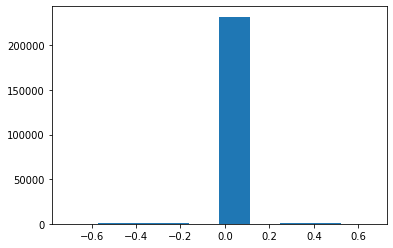

In [151]:
plt.hist(sent_xyz[3],bins=10)

In [146]:
sia.polarity_scores('The meal was atrocious')

{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

In [172]:
[syn for syn in wordnet.synsets('run') if syn.pos() == 'v']

[Synset('run.v.01'),
 Synset('scat.v.01'),
 Synset('run.v.03'),
 Synset('operate.v.01'),
 Synset('run.v.05'),
 Synset('run.v.06'),
 Synset('function.v.01'),
 Synset('range.v.01'),
 Synset('campaign.v.01'),
 Synset('play.v.18'),
 Synset('run.v.11'),
 Synset('tend.v.01'),
 Synset('run.v.13'),
 Synset('run.v.14'),
 Synset('run.v.15'),
 Synset('run.v.16'),
 Synset('prevail.v.03'),
 Synset('run.v.18'),
 Synset('run.v.19'),
 Synset('carry.v.15'),
 Synset('run.v.21'),
 Synset('guide.v.05'),
 Synset('run.v.23'),
 Synset('run.v.24'),
 Synset('run.v.25'),
 Synset('run.v.26'),
 Synset('run.v.27'),
 Synset('run.v.28'),
 Synset('run.v.29'),
 Synset('run.v.30'),
 Synset('run.v.31'),
 Synset('run.v.32'),
 Synset('run.v.33'),
 Synset('run.v.34'),
 Synset('ply.v.03'),
 Synset('hunt.v.01'),
 Synset('race.v.02'),
 Synset('move.v.13'),
 Synset('melt.v.01'),
 Synset('ladder.v.01'),
 Synset('run.v.41')]